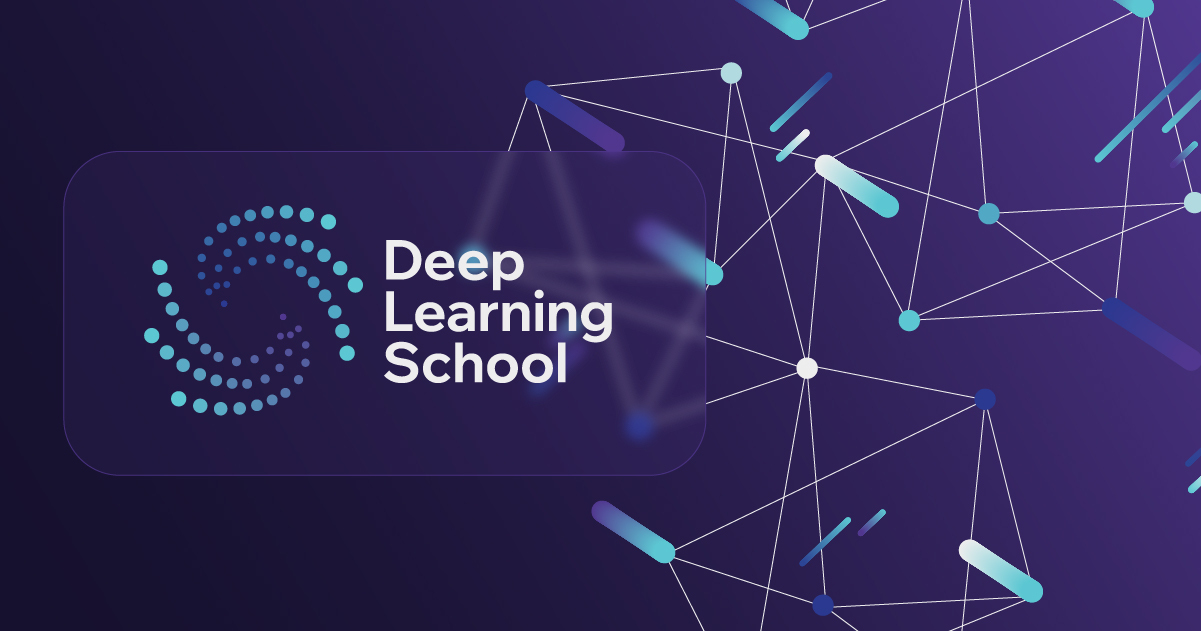

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
!pip install -U albumentations
!pip install torchinfo
!pip install warmup-scheduler
!pip install torchmetrics

In [2]:
import io
import cv2
import gc
import timm
import torch
import torchinfo
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
import torch.optim as optim
import torchvision.ops as ops

from PIL import Image
from torch import Tensor
from tqdm.auto import tqdm
from torch.optim import lr_scheduler
from functools import partial
from torchvision import transforms
from torchvision.ops import nms, box_iou, sigmoid_focal_loss
from torch.utils.data import Dataset, DataLoader
from collections import Counter, defaultdict
from torchvision.ops import distance_box_iou_loss
from torchmetrics.detection import MeanAveragePrecision
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import WeightedRandomSampler
from warmup_scheduler import GradualWarmupScheduler
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [4]:
# Определяем константы для цвета и названий классов
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Создаем датасет для предобработки данных

In [5]:
def xywh_to_xyxy(boxes_list):
    """
    boxes_list: List of [x_min, y_min, w, h], может быть пустым.
    Возвращает Tensor shape (N,4) в формате [x1, y1, x2, y2].
    """
    # 1) Превращаем в numpy array формы (K,4) или (0,4)
    if len(boxes_list) == 0:
        boxes_arr = np.zeros((0, 4), dtype=np.float32)
    else:
        boxes_arr = np.array(boxes_list, dtype=np.float32).reshape(-1, 4)

    # 2) Конвертация без прямой индексации по пустому массиву
    # Если есть хоть один бокс:
    if boxes_arr.shape[0] > 0:
        x1 = boxes_arr[:, 0]
        y1 = boxes_arr[:, 1]
        w  = boxes_arr[:, 2]
        h  = boxes_arr[:, 3]
        x2 = x1 + w
        y2 = y1 + h
        boxes_xyxy = np.stack([x1, y1, x2, y2], axis=1)  # (K,4)
    else:
        boxes_xyxy = boxes_arr  # просто (0,4)

    # 3) В torch.Tensor
    return torch.from_numpy(boxes_xyxy)

In [6]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        #xywh_to_xyxy(boxes):
        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        A.Resize(640, 640),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.HueSaturationValue(p=0.3),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.Resize(640, 640),
        ToTensorV2(),
    ]
)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Не забываем инициализировать наш датасет

In [8]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

In [9]:
# Балансировка классов
# Считаем, в скольких изображениях встречается каждый класс
class_counts = Counter()
for _, target in train_dataset:
    labels = target['labels'].tolist()         # список меток в этом изображении
    unique = set(labels)                       # чтобы не считать дубликаты в одном img
    for lab in unique:
        class_counts[lab] += 1
print("Изображениий на класс:", class_counts)

# Для каждого изображения вычисляем вес = среднее (1 / count[class]) по его классам
image_weights = []
for _, target in train_dataset:
    labels = target['labels'].tolist()
    unique = set(labels)
    # если вдруг нет объектов, можно дать минимальный вес (или пропустить)
    if len(unique)==0:
        image_weights.append(0.0)
    else:
        ws = [1.0 / class_counts[lab] for lab in unique]
        image_weights.append(float(np.mean(ws)))

# Проверка
assert len(image_weights) == len(train_dataset)

# Собираем WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=image_weights,
    num_samples=len(image_weights),
    replacement=True
)

Изображениий на класс: Counter({0: 321, 1: 284, 2: 76, 3: 37})


## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [10]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3), unfreeze_last=0):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)

        # Определяем количество блоков (stages)
        self.blocks = self.backbone.blocks
        num_blocks = len(self.blocks)

        # Замораживаем все параметры
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Размораживаем k последних блоков
        if unfreeze_last > 0:
            for block in self.blocks[-unfreeze_last:]:
                for param in block.parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [11]:
model = Backbone(model_name="tf_efficientnet_b4").to(device)
model.eval()

dummy_input = torch.randn(1, 3, 640, 640, device=device)
with torch.no_grad():
    outputs = model(dummy_input)

print("Тип:", type(outputs))
print("Число уровней:", len(outputs))
for idx, feat in enumerate(outputs):
    print(f"Уровень {idx}: shape={feat.shape}")

Тип: <class 'list'>
Число уровней: 3
Уровень 0: shape=torch.Size([1, 56, 80, 80])
Уровень 1: shape=torch.Size([1, 160, 40, 40])
Уровень 2: shape=torch.Size([1, 448, 20, 20])


### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [12]:
class FPNNeck(nn.Module):
    def __init__(self, in_channels_list=[40, 112, 320], out_channels=256):
        super().__init__()
        # Латеральные 1x1 свёртки для выравнивания каналов
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(channels, out_channels, kernel_size=1)
            for channels in in_channels_list
        ])
        # 3x3 свёртки после слияния
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])

    def forward(self, features):
        # Bottom-Up путь
        laterals = [lateral_conv(f) for lateral_conv, f in zip(self.lateral_convs, features)]

        # Top-Down путь
        fpn_outs = [laterals[-1]]
        for i in range(len(laterals) - 2, -1, -1):
            top_down = F.interpolate(fpn_outs[0], scale_factor=2, mode='nearest')
            fpn_out = laterals[i] + top_down
            fpn_outs.insert(0, fpn_out)

        # Применяем 3x3 свёртки
        fpn_outs = [fpn_conv(fpn_out) for fpn_conv, fpn_out in zip(self.fpn_convs, fpn_outs)]
        return fpn_outs

In [13]:
in_ch = [40, 112, 320]
fpn = FPNNeck(in_channels_list=in_ch, out_channels=256)
# пример входных тензоров
P3 = torch.randn(1, 40, 80, 80)
P4 = torch.randn(1, 112, 40, 40)
P5 = torch.randn(1, 320, 20, 20)
outputs = fpn([P3, P4, P5])
for i, out in enumerate(outputs):
    print(f"Форма выхода FPN P{i+3}: {out.shape}")

Форма выхода FPN P3: torch.Size([1, 256, 80, 80])
Форма выхода FPN P4: torch.Size([1, 256, 40, 40])
Форма выхода FPN P5: torch.Size([1, 256, 20, 20])


In [14]:
class PANNeck(nn.Module):
    """
    Сеть агрегации признаков по путям (PANet) для детекции объектов.
    - Top-down путь, похожий на FPN, с последующим bottom-up агрегированием.
    """
    def __init__(self, in_channels_list=[56, 160, 448], out_channels=256):
        """
        Args:
            in_channels_list: список числа каналов C_i у выходов бэкбона,
                              упорядоченных от высокого к низкому разрешению, например [C3, C4, C5].
            out_channels: число каналов для всех промежуточных карт признаков.
        """
        super().__init__()
        # Латеральные свёртки 1×1 для выравнивания числа каналов
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(C, out_channels, kernel_size=1)
            for C in in_channels_list
        ])
        # Свёртки 3×3 после top-down fusion
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])
        # Свёртки 3×3 для bottom-up агрегации (кроме первого уровня)
        self.bu_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(len(in_channels_list)-1)
        ])

    def forward(self, feats):
        """
        Args:
            feats: список карт признаков [P3, P4, P5, ...], от высокого к низкому разрешению
        Returns:
            bu_feats: список агрегированных карт признаков той же длины
        """
        # 1) Создаём латеральные карты
        laterals = [l_conv(f) for l_conv, f in zip(self.lateral_convs, feats)]

        # 2) Top-down путь (FPN)
        # начинаем с высшего уровня
        td_feats = [None] * len(laterals)
        td_feats[-1] = laterals[-1]
        for i in range(len(laterals)-2, -1, -1):
            size = laterals[i].shape[-2:]
            # интерполяция и сложение с латеральной картой
            td_feats[i] = laterals[i] + F.interpolate(td_feats[i+1], size=size, mode='nearest')

        # Применяем свёртки 3×3 после fusion
        fpn_outs = [conv(td) for conv, td in zip(self.fpn_convs, td_feats)]

        # 3) Bottom-up путь агрегации
        bu_feats = [fpn_outs[0]]  # начинаем с первого (низшего) уровня
        for i in range(1, len(fpn_outs)):
            # даунсемплинг предыдущей агрегированной карты
            down = F.max_pool2d(bu_feats[i-1], kernel_size=2, stride=2)
            # складываем с текущей FPN-картой и применяем свёртку
            agg = fpn_outs[i] + down
            bu_feats.append(self.bu_convs[i-1](agg))

        return bu_feats

In [15]:
in_ch = [56, 160, 448]
pan = PANNeck(in_ch, out_channels=256)
# пример входных тензоров
P3 = torch.randn(1, 56, 80, 80)
P4 = torch.randn(1, 160, 40, 40)
P5 = torch.randn(1, 448, 20, 20)
outputs = pan([P3, P4, P5])
for i, out in enumerate(outputs):
    print(f"Форма выхода PAN P{i+3}: {out.shape}")

Форма выхода PAN P3: torch.Size([1, 256, 80, 80])
Форма выхода PAN P4: torch.Size([1, 256, 40, 40])
Форма выхода PAN P5: torch.Size([1, 256, 20, 20])


### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [16]:
class DecoupledHead(nn.Module):
    """
    Decoupled Head из статьи "Task-aligned One-stage Object Detection" (TAL, arXiv:2107.08430).
    В каждой точке признакового уровня отдельно выстраиваются две ветви:
      - ветвь классификации (classification branch)
      - ветвь регрессии боксов + objectness (regression branch)
    """
    def __init__(self, in_channels: int, num_classes: int, num_anchors: int = 1,
                 feat_channels: int = 256, num_layers: int = 2):
        """
        Args:
            in_channels: число входных каналов на каждом FPN‑уровне.
            num_classes: число классов для предсказания.
            num_anchors: число якорей на одну точку (для anchor-based моделей).
            feat_channels: число каналов в скрытых слоях голова (обычно 256).
            num_layers: глубина каждой ветви (количество 3×3 conv слоёв).
        """
        super().__init__()
        # Общий "стем" — 1×1 conv для подготовки фичей
        self.stem = nn.Conv2d(in_channels, feat_channels, kernel_size=1, bias=False)
        # Ветвь классификации: серия conv 3×3 + ReLU
        self.cls_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feat_channels, feat_channels, kernel_size=3, padding=1, bias=False),
                nn.ReLU(inplace=True)
            )
            for _ in range(num_layers)
        ])
        # Прогноз классов: 1×1 conv → num_classes * num_anchors каналов
        self.cls_pred = nn.Conv2d(feat_channels, num_classes * num_anchors, kernel_size=1)

        # Ветвь регрессии: серия conv 3×3 + ReLU
        self.reg_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feat_channels, feat_channels, kernel_size=3, padding=1, bias=False),
                nn.ReLU(inplace=True)
            )
            for _ in range(num_layers)
        ])
        # Прогноз смещений боксов: 1×1 conv → 4 * num_anchors каналов
        self.reg_pred = nn.Conv2d(feat_channels, 4 * num_anchors, kernel_size=1)
        # Прогноз objectness score: 1×1 conv → 1 * num_anchors каналов
        self.obj_pred = nn.Conv2d(feat_channels, 1 * num_anchors, kernel_size=1)

        # Инициализация весов
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, features):
        """
        Args:
            features: список тензоров [B, in_channels, H_i, W_i] для каждого уровня FPN.
        Returns:
            cls_outputs: list из B×(Hi*Wi*num_anchors)×num_classes logits
            obj_outputs: list из B×(Hi*Wi*num_anchors) objectness logits
            reg_outputs: list из B×(Hi*Wi*num_anchors)×4 смещений ббоксов
        """
        cls_outputs = []
        obj_outputs = []
        reg_outputs = []

        for x in features:
            # Подготовка фич
            x = self.stem(x)

            # Классификационная ветвь
            cls_feat = x
            for conv in self.cls_convs:
                cls_feat = conv(cls_feat)
            cls_out = self.cls_pred(cls_feat)

            # Регрессионная ветвь
            reg_feat = x
            for conv in self.reg_convs:
                reg_feat = conv(reg_feat)
            reg_out = self.reg_pred(reg_feat)
            obj_out = self.obj_pred(reg_feat)

            cls_outputs.append(cls_out)
            reg_outputs.append(reg_out)
            obj_outputs.append(obj_out)

        return cls_outputs, obj_outputs, reg_outputs

In [17]:
# Допустим, на каждом уровне FPN 256 каналов, 80 классов, 3 якоря
head = DecoupledHead(in_channels=256, num_classes=80, num_anchors=3,
                     feat_channels=256, num_layers=2)
# Генерируем dummy фичи для 3 уровней FPN
feats = [torch.randn(2, 256, s, s) for s in (80, 40, 20)]
cls_outs, obj_outs, reg_outs = head(feats)
for i, (c, o, r) in enumerate(zip(cls_outs, obj_outs, reg_outs)):
    B, _, H, W = c.shape
    print(f"Уровень {i}: cls {c.shape}, obj {o.shape}, reg {r.shape}")

Уровень 0: cls torch.Size([2, 240, 80, 80]), obj torch.Size([2, 3, 80, 80]), reg torch.Size([2, 12, 80, 80])
Уровень 1: cls torch.Size([2, 240, 40, 40]), obj torch.Size([2, 3, 40, 40]), reg torch.Size([2, 12, 40, 40])
Уровень 2: cls torch.Size([2, 240, 20, 20]), obj torch.Size([2, 3, 20, 20]), reg torch.Size([2, 12, 20, 20])


Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [18]:
class Detector(nn.Module):
    """
    Детектор на основе Backbone (EfficientNet), PANet и DecoupledHead.
    """
    def __init__(self,
                 backbone_model_name="efficientnet_b0",
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 input_size=(640, 640),
                 unfreeze_last=0):
        super().__init__()
        self.num_classes = num_classes

        # 1) Backbone
        self.backbone = Backbone(
            model_name=backbone_model_name,
            out_indices=(-3, -2, -1),  # P3, P4, P5
            unfreeze_last=unfreeze_last
        )

        # Получаем каналы из feature_info
        in_channels_list = self.backbone.backbone.feature_info.channels()

        # 2) PANet neck
        self.neck = PANNeck(in_channels_list=in_channels_list, out_channels=neck_n_channels)

        # 3) Decoupled Head
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.head = DecoupledHead(
            in_channels=neck_n_channels,
            num_classes=num_classes,
            num_anchors=num_anchors,
            feat_channels=neck_n_channels,
            num_layers=2
        )

        # 4) Anchor generation (под P3, P4, P5)
        num_levels = len(in_channels_list)
        sizes = tuple([tuple(anchor_sizes)] * num_levels)
        ratios = tuple([tuple(anchor_ratios)] * num_levels)
        anchor_generator = AnchorGenerator(sizes=sizes, aspect_ratios=ratios)

        # Получаем редукции и переворачиваем тоже
        reductions = self.backbone.backbone.feature_info.reduction()[::-1]
        grid_sizes = [(input_size[0] // r, input_size[1] // r) for r in reductions]
        strides = [(r, r) for r in reductions]

        # Генерируем якоря и конкатенируем
        anchors_per_level = anchor_generator.grid_anchors(grid_sizes, strides)
        anchors = torch.cat(anchors_per_level, dim=0)  # [total_anchors, 4]

        # Вычисляем центры и размеры анкоров
        centers = (anchors[:, :2] + anchors[:, 2:]) / 2  # [total_anchors, 2]
        sizes = anchors[:, 2:] - anchors[:, :2]          # [total_anchors, 2]

        # Сохраняем в буферы
        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", centers)
        self.register_buffer("anchor_sizes", sizes)

    def forward(self, x):
        B = x.size(0)
        # 1) Backbone → списком [P3, P4, P5]
        feats = self.backbone(x)           # выдаёт [P5, P4, P3]
        # 2) Neck
        neck_feats = self.neck(feats)      # [P5, P4, P3]
        # 3) Head
        cls_outs, obj_outs, reg_outs = self.head(neck_feats)

        # 4) Flatten predictions с каждого уровня
        cls_list, obj_list, reg_list = [], [], []
        for cls_pred, obj_pred, reg_pred in zip(cls_outs, obj_outs, reg_outs):
            # cls_pred: [B, C_a, H, W] → [B, H*W*A, num_classes]
            C_a = cls_pred.shape[1]
            cls_l = (cls_pred
                     .permute(0, 2, 3, 1)
                     .contiguous()
                     .view(B, -1, self.num_classes))
            # obj_pred: [B, A, H, W] → [B, H*W*A]
            obj_l = (obj_pred
                     .permute(0, 2, 3, 1)
                     .contiguous()
                     .view(B, -1))
            # reg_pred: [B, 4*A, H, W] → [B, H*W*A, 4]
            reg_l = (reg_pred
                     .permute(0, 2, 3, 1)
                     .contiguous()
                     .view(B, -1, 4))
            cls_list.append(cls_l)
            obj_list.append(obj_l)
            reg_list.append(reg_l)

        # 5) Concatenate по всем уровням
        cls_logits = torch.cat(cls_list, dim=1)  # [B, total_anchors, num_classes]
        obj_logits = torch.cat(obj_list, dim=1)  # [B, total_anchors]
        bbox_offsets = torch.cat(reg_list, dim=1)  # [B, total_anchors, 4]

        if self.training:
            # Для обучения возвращаем offsets, objectness logits, class logits
            return bbox_offsets, obj_logits, cls_logits

        # 6) Для инференса декодируем боксы
        bboxes = self.decode_bboxes(bbox_offsets)     # [B, total_anchors, 4] в (x1,y1,w,h)
        confidence = torch.sigmoid(obj_logits)        # [B, total_anchors]
        cls_probs = torch.softmax(cls_logits, dim=-1) # [B, total_anchors, num_classes]
        return bboxes, confidence, cls_probs

    def decode_bboxes(self, bbox_offsets):
        # bbox_offsets: [B, total_anchors, 4] = [tx, ty, tw, th]
        tx = bbox_offsets[..., 0]
        ty = bbox_offsets[..., 1]
        tw = bbox_offsets[..., 2]
        th = bbox_offsets[..., 3]

        # center_x = cx_anchor + sigmoid(tx) * w_anchor
        # center_y = cy_anchor + sigmoid(ty) * h_anchor
        cx = self.anchor_centers[:, 0] + torch.sigmoid(tx) * self.anchor_sizes[:, 0]
        cy = self.anchor_centers[:, 1] + torch.sigmoid(ty) * self.anchor_sizes[:, 1]

        # w = exp(tw) * w_anchor
        # h = exp(th) * h_anchor
        w = torch.exp(tw) * self.anchor_sizes[:, 0]
        h = torch.exp(th) * self.anchor_sizes[:, 1]

        x1 = cx - 0.5 * w
        y1 = cy - 0.5 * h
        return torch.stack([x1, y1, w, h], dim=-1)

In [19]:
# Параметры теста
# B (Batch size) – число изображений в одном батче
# C (Channels) – число каналов у каждого изображения (обычно 3 для RGB‑картинок).
# H (Height) – высота (число строк) каждого изображения, тут 640 пикселей.
# W (Width) – ширина (число столбцов), тоже 640 пикселей.
B, C, H, W = 2, 3, 640, 640

# Проверяем режим TRAIN
model = Detector(num_classes=4)
model.train()
x = torch.randn(B, C, H, W)
offsets, obj_logits, cls_logits = model(x)

A = model.anchor_centers.size(0)
assert offsets.shape == (B, A, 4), f"Train offsets: expected {(B,A,4)}, got {offsets.shape}"
assert obj_logits.shape == (B, A), f"Train obj_logits: expected {(B,A)}, got {obj_logits.shape}"
assert cls_logits.shape == (B, A, model.num_classes), f"Train cls_logits: expected {(B,A,{model.num_classes})}, got {cls_logits.shape}"

# Проверяем режим EVAL
model.eval()
with torch.no_grad():
    bboxes, confidence, cls_probs = model(x)
assert bboxes.shape == (B, A, 4), f"Infer bboxes: expected {(B,A,4)}, got {bboxes.shape}"
assert confidence.shape == (B, A), f"Infer confidence: expected {(B,A)}, got {confidence.shape}"
assert cls_probs.shape == (B, A, model.num_classes), f"Infer cls_probs: expected {(B,A,{model.num_classes})}, got {cls_probs.shape}"

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [20]:
def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))

def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

In [21]:
def assign_target(anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)
    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls
    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (x_min, y_min, w, h)
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]
    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy) # [num_anchors, num_gt]
    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)
    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1

    # Присваиваем предсказание с самым большим IoU для GT
    # у которых не нашлось ни оного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1
    return target_offsets, target_objectness, target_cls

In [22]:
def tal_assigner(
    anchors: torch.Tensor,
    gt_boxes: torch.Tensor,
    gt_labels: torch.Tensor,
    num_classes: int,
    cls_scores: torch.Tensor,
    top_k: int = 13,
    alpha: float = 1.0,
    beta: float = 1.0,
    neg_th: float = 0.3,
    get_target_offset_func = get_target_offset
):


    device = anchors.device

    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)
    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls

    # подготовка gt_xyxy на том же устройстве
    gt_xyxy = gt_boxes.clone().to(device)
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]

    overlaps      = box_iou(anchors, gt_xyxy)
    cls_scores_gt = cls_scores[:, gt_labels].to(device)
    alignment     = (cls_scores_gt**alpha) * (overlaps**beta)

    N_gt = gt_xyxy.size(0)
    k    = min(top_k, num_anchors)
    _, candidate_idxs = alignment.topk(k, dim=0, largest=True)

    anc_cx   = (anchors[:,0] + anchors[:,2]) / 2
    anc_cy   = (anchors[:,1] + anchors[:,3]) / 2
    flat_anc = candidate_idxs.reshape(-1)
    flat_gt  = torch.arange(N_gt, device=device).unsqueeze(0).expand(k, N_gt).reshape(-1)

    cx_flat = anc_cx[flat_anc]
    cy_flat = anc_cy[flat_anc]
    x1g = gt_xyxy[flat_gt, 0]
    y1g = gt_xyxy[flat_gt, 1]
    x2g = gt_xyxy[flat_gt, 2]
    y2g = gt_xyxy[flat_gt, 3]
    inside = (cx_flat>=x1g)&(cx_flat<=x2g)&(cy_flat>=y1g)&(cy_flat<=y2g)

    flat_metrics = alignment.reshape(-1)[flat_anc * N_gt + flat_gt]
    pos_mask = (flat_metrics>0) & inside

    pos_ancs = flat_anc[pos_mask]
    pos_gts  = flat_gt[pos_mask]

    # разрешаем конфликты по максимальному IoU
    ious_flat = overlaps.reshape(-1)[pos_ancs * N_gt + pos_gts]
    order = torch.argsort(ious_flat, descending=True)
    for idx in order:
        a = pos_ancs[idx].item()
        g = pos_gts[idx].item()
        if target_objectness[a] == 0:
            target_objectness[a] = 1
            target_cls[a, gt_labels[g]] = 1
            target_offsets[a] = get_target_offset(anchors[a], gt_xyxy[g])

    # для всех анкорoв, которые не стали positive,
    # если их max IoU >= neg_th => ignore
    max_iou_per_anchor, _ = overlaps.max(dim=1)         # [N_anc]
    ign_mask = (max_iou_per_anchor >= neg_th) & (target_objectness == 0)
    target_objectness[ign_mask] = -1

    # гарантируем по одному anchor на каждый GT
    for g in range(N_gt):
        pos_mask_for_gt = (target_objectness == 1) & (target_cls[:, gt_labels[g]] == 1)
        if not pos_mask_for_gt.any():
            best_a = torch.argmax(overlaps[:, g]).item()
            target_objectness[best_a] = 1
            target_cls[best_a, gt_labels[g]] = 1
            target_offsets[best_a] = get_target_offset_func(anchors[best_a], gt_xyxy[g])

    return target_offsets, target_objectness, target_cls


In [23]:
# Заготовка функции get_target_offset
def get_target_offset_test(anchor_xyxy, gt_xyxy):
    """
    Для тестов вернём просто разницу координат углов:
    dx1 = x1_gt - x1_anc, dy1 = y1_gt - y1_anc,
    dx2 = x2_gt - x2_anc, dy2 = y2_gt - y2_anc
    """
    return gt_xyxy - anchor_xyxy

In [24]:
def test_no_gt():
    # Случай без GT: все анкоры должны быть отрицательными
    anchors = torch.tensor([[0,0,10,10],[20,20,5,5]], dtype=torch.float32)  # (x,y,w,h)
    gt_boxes = torch.empty((0,4), dtype=torch.float32)
    gt_labels = torch.empty((0,), dtype=torch.long)
    cls_scores = torch.randn(2, 3)  # два анкoра, 3 класса

    toffs, tobj, tcls = tal_assigner(
        anchors, gt_boxes, gt_labels, num_classes=3, cls_scores=cls_scores,
        get_target_offset_func=get_target_offset_test
    )
    assert tobj.shape == (2,)
    assert tobj.eq(0).all(), "Без GT все анкоры должны быть 0 (negative)"
    assert tcls.eq(0).all(), "В absence GT классы должны быть нулями"
    print("test_no_gt passed")

def test_single_gt_inside_outside():
    # Один GT, один анкор внутри и один снаружи
    anchors = torch.tensor([
        [0,0,10,10],   # внутри
        [20,20,5,5]    # снаружи
    ], dtype=torch.float32)
    # GT в формате x,y,w,h
    gt_boxes = torch.tensor([[0,0,10,10]], dtype=torch.float32)
    gt_labels = torch.tensor([2], dtype=torch.long)  # класс = 2
    # Делаем cls_scores так, чтобы уверенность была высокая для класса 2
    cls_scores = torch.tensor([
        [0.1,0.1,0.8],
        [0.2,0.3,0.5]
    ], dtype=torch.float32)

    toffs, tobj, tcls = tal_assigner(
        anchors, gt_boxes, gt_labels, num_classes=3, cls_scores=cls_scores,
        top_k=1, alpha=1.0, beta=1.0, neg_th=0.3,
        get_target_offset_func=get_target_offset_test
    )
    # Первый анкор должен стать positive:
    assert tobj[0] == 1, "Анкор внутри GT должен быть positive"
    # Второй анкор — negative или ignore, но не positive
    assert tobj[1] in (0, -1), "Анкор снаружи GT не должен быть positive"
    # Проверяем, что смещение совпадает с разницей углов
    expected_offset = get_target_offset(
        torch.tensor([0,0,10,10], dtype=torch.float32) + torch.tensor([0,0,10,10]), # преобразуем в xyxy
        torch.tensor([0,0,10,10], dtype=torch.float32) + torch.tensor([0,0,10,10])
    )
    assert torch.allclose(toffs[0], expected_offset)
    # Проверяем one-hot класс для positive анкoра
    assert tcls[0,2] == 1 and tcls[0,:2].sum() == 0, "Positive анкор должен иметь one-hot метку"
    print("test_single_gt_inside_outside passed")

def test_multiple_gt_conflict():
    # Два GT, один анкор по центру, должен быть назначен тому с большей IoU
    anchors = torch.tensor([[0,0,50,50]], dtype=torch.float32)
    # два GT: первый w=h=30, второй w=h=40
    gt_boxes = torch.tensor([[0,0,30,30],[0,0,40,40]], dtype=torch.float32)
    gt_labels = torch.tensor([0,1], dtype=torch.long)
    cls_scores = torch.ones(1,2) * 0.9  # одинаковая уверенность

    toffs, tobj, tcls = tal_assigner(
        anchors, gt_boxes, gt_labels, num_classes=2, cls_scores=cls_scores,
        top_k=2, alpha=1.0, beta=1.0, neg_th=0.3,
        get_target_offset_func=get_target_offset_test
    )
    # Анкор должен быть assigned, и выбран GT с большей площадью (второй)
    assert tobj[0] == 1
    assert tcls[0,1] == 1, "Анкор должен быть назначен GT с бОльшим IoU (GT индекс 1)"
    print("test_multiple_gt_conflict passed")

test_no_gt()
test_single_gt_inside_outside()
test_multiple_gt_conflict()

test_no_gt passed
test_single_gt_inside_outside passed
test_multiple_gt_conflict passed


### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [25]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [26]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [27]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction='mean').item()}")

 DIoU: 0.9748895764350891


In [28]:
class DIoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, pred_boxes, gt_boxes):
        # Извлекаем координаты
        x1_p, y1_p, x2_p, y2_p = pred_boxes[..., 0], pred_boxes[..., 1], pred_boxes[..., 2], pred_boxes[..., 3]
        x1_g, y1_g, x2_g, y2_g = gt_boxes[..., 0], gt_boxes[..., 1], gt_boxes[..., 2], gt_boxes[..., 3]

        # Площади ббоксов
        area_p = (x2_p - x1_p) * (y2_p - y1_p)
        area_g = (x2_g - x1_g) * (y2_g - y1_g)

        # Пересечение
        x1_i = torch.max(x1_p, x1_g)
        y1_i = torch.max(y1_p, y1_g)
        x2_i = torch.min(x2_p, x2_g)
        y2_i = torch.min(y2_p, y2_g)

        intersection = torch.clamp(x2_i - x1_i, min=0) * torch.clamp(y2_i - y1_i, min=0)

        # Объединение
        union = area_p + area_g - intersection
        iou = intersection / (union + self.eps)

        # Расстояние между центрами
        center_x_p = (x1_p + x2_p) / 2
        center_y_p = (y1_p + y2_p) / 2
        center_x_g = (x1_g + x2_g) / 2
        center_y_g = (y1_g + y2_g) / 2

        distance = (center_x_p - center_x_g) ** 2 + (center_y_p - center_y_g) ** 2

        # Диагональ выпуклой оболочки (а не площадь!)
        x1_c = torch.min(x1_p, x1_g)
        y1_c = torch.min(y1_p, y1_g)
        x2_c = torch.max(x2_p, x2_g)
        y2_c = torch.max(y2_p, y2_g)

        convex_dist = (x2_c - x1_c) ** 2 + (y2_c - y1_c) ** 2
        convex_dist = torch.where(convex_dist > 0, convex_dist, torch.tensor(self.eps, device=convex_dist.device))

        # DIoU Loss
        diou_term = distance / convex_dist
        diou_loss = 1 - iou + diou_term

        return diou_loss.mean()

In [29]:
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

diou_loss = DIoULoss()
# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [30]:
class SigmoidFocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        targets = targets.to(dtype=logits.dtype, device=logits.device)
        loss = sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        return loss

In [31]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """
    def __init__(self,
            bbox_loss=None, obj_loss=None, cls_loss=None,
            weight_bbox=5, weight_obj=1, weight_cls=1
        ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

#        pos = int((target_obj == 1).sum().item())
#        neg = int((target_obj == 0).sum().item())
        #ratio = pos / (neg + 1e-6)
        #print(f"pos/neg = {pos}/{neg}, ratio = {ratio:.3f}")

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)

        #print(f"bbox_loss={loss_bbox.item():.4f}, obj_loss={loss_obj.item():.4f}, cls_loss={loss_cls.item():.4f}")
        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

In [32]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)

            anchors = self.model.anchors.view(-1, 4)
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)
                # выбираем какие якоря будут использоваться при расчете лосса.

                outputs_ixs = [out[ix] for out in outputs]
#                assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels, num_classes=model.num_classes)

                # для tal_assigner
                cls_scores = torch.softmax(outputs_ixs[2], dim=-1)
                assigned_targets = self.assign_target_method(
                    anchors=anchors,
                    gt_boxes=gt_boxes,
                    gt_labels=gt_labels,
                    num_classes=model.num_classes,
                    cls_scores=cls_scores,
                    top_k=13,
                    alpha=1.0,
                    beta=1.0)

                # Считаем лосс на основании предсказаний модели и таргетов.
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()

    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                           max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            #print([len(p["boxes"]) for p in predicts])
            #print(predicts[0]['boxes'])
            metric.update(predicts, targets)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        fig, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        if nrows == 1:
            ax = [ax]

        # График train loss
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(
            np.arange(1, len(self.epoch_loss)+1) * len(self.train_dataloader),
            self.epoch_loss,
            color="tab:orange",
            label="Train epoch Loss"
        )
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        if self.val_metric:
            epochs = np.arange(1, len(self.val_metric)+1) * self.val_every
            ax[1].plot(epochs, np.array(self.val_metric) * 100,
                       color="tab:green", marker='o', label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Validation mAP")
            ax[1].set_xlabel("Epoch")
            ax[1].set_ylabel("mAP (%)")
            ax[1].legend()

        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=20,
                              shuffle=False, collate_fn=collate_fn,
                              sampler=sampler,
                              num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=8,
                             shuffle=False, collate_fn=collate_fn,
                             num_workers=2,pin_memory=True)

In [34]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [35]:
lr = 1e-3
num_epochs = 10

model = Detector("tf_efficientnet_b4", num_classes=4,
                 anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2), unfreeze_last=2).to(device)

model = model.to(device)    # переносим на первую GPU

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-5)

iou_loss = DIoULoss()
focal_loss = SigmoidFocalLoss()
compute_loss = ComputeLoss(iou_loss, focal_loss, focal_loss, weight_bbox=10)

runner = Runner(model, compute_loss, optimizer, train_dataloader, device=device,
                score_threshold=0.1,
#                assign_target_method=assign_target,
#                assign_target_kwargs={"neg_th":0.4, "pos_th":0.6},
                assign_target_method = tal_assigner,
                assign_target_kwargs={"alpha":0.5, "beta":0.5},
                scheduler=scheduler,
                val_every=1,
                val_dataloader=test_dataloader)

In [36]:
clear_gpu_memory()
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

In [54]:
runner.validate(test_dataloader)

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

0.0

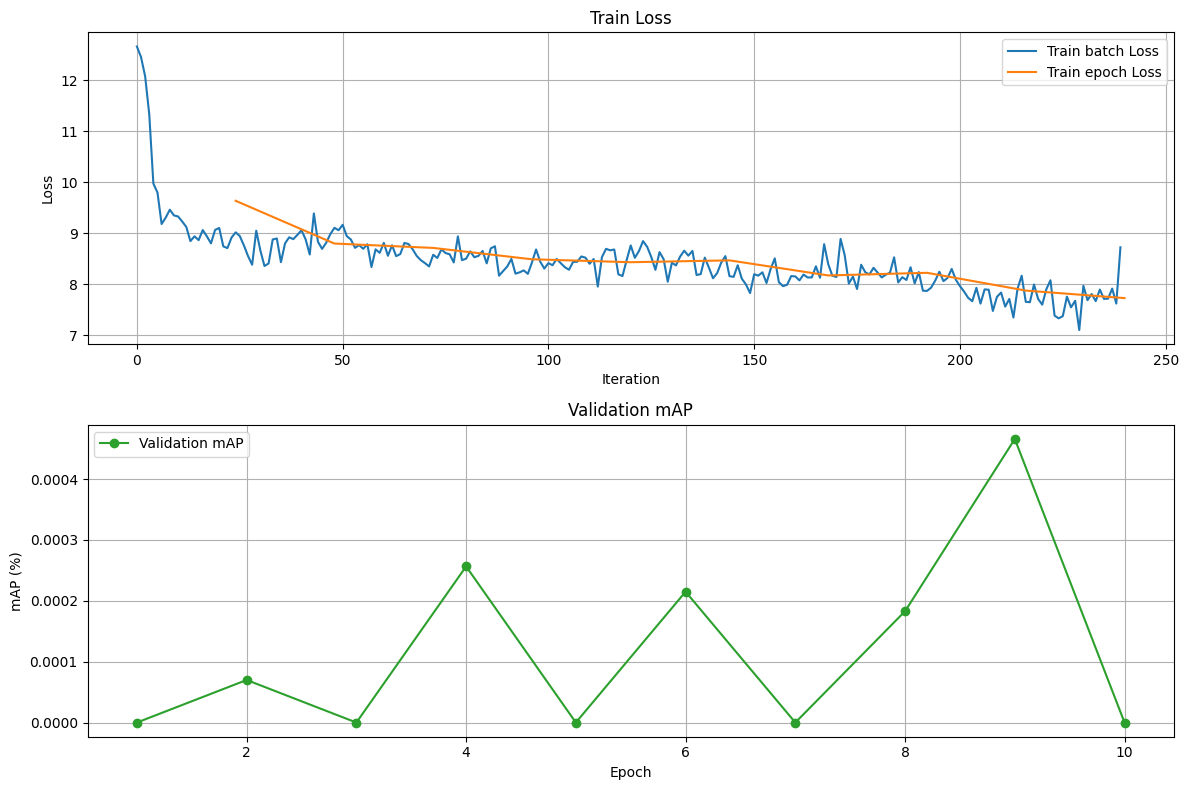

In [55]:
runner.plot_loss(row_figsize=4)

In [46]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [47]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row['image']['bytes']))
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        img = np.array(image)
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = class_to_name[label]
            img = add_bbox(img, bbox, label=str(class_name), color=color)
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

In [48]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_to_color[label+1]
                label = class_to_name[label+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [56]:
test_iter = iter(test_dataloader)

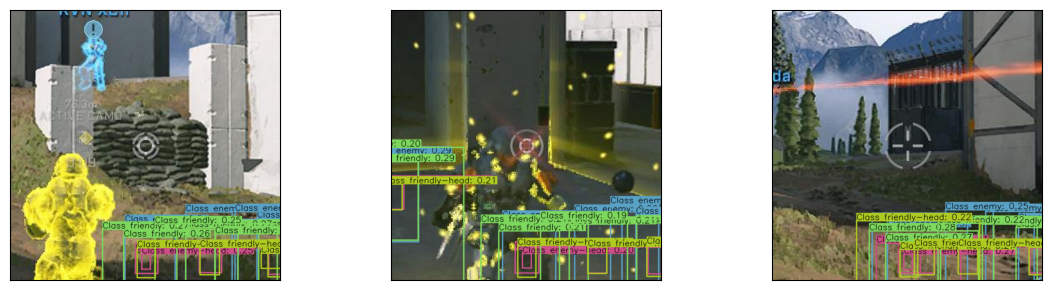

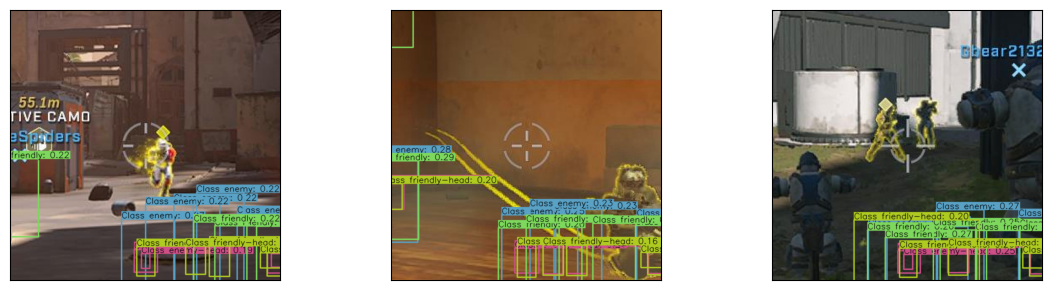

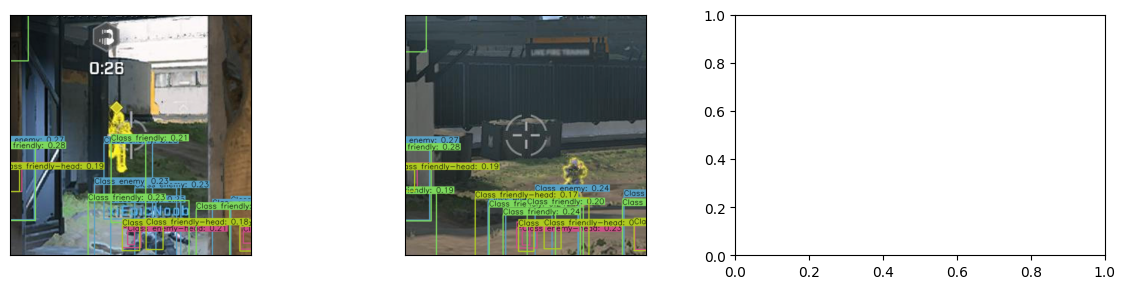

In [57]:
score_threshold = 0.1
nms_threshold = 0.4

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

In [51]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def compute_coco_map(model, dataloader, device, score_threshold=0.01, nms_threshold=0.5, num_classes=4):
    """ Считаем mAP модели на данных из `dataloader`. """
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for images, targets in tqdm(dataloader, desc="Dataset Evaluation"):
        # Делаем предсказание для всех картинок в батче
        predictions = predict(model, images, device, score_threshold, nms_threshold)
        # Сохраняем изначальные картинки, предсказания и таргет в формате COCO
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Сохраняем предсказания модели в формате COCO
            img_pred = predictions[i]
            for box, cls, sc in zip(img_pred["boxes"], img_pred["labels"], img_pred["scores"]):
                detection = {
                    "image_id": image_id,
                    "category_id": cls + 1,  # Классы в COCO начинаются с 1
                    "bbox": list(box),  # Бокс в COCO формате [x, y, w, h]
                    "score": sc
                }
                all_detections.append(detection)

            # Сохраняем таргет в формате COCO
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": label + 1,
                    "bbox": box,
                    "area": box[2] * box[3],
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(model.num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = class_to_name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize();
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap

In [52]:
score_threshold = 0.1
nms_threshold = 0.5
compute_coco_map(model, test_dataloader, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)

Dataset Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.5

Что было сделано по факту
* Регулировка Loss‑Weights, баланс между локализацией и классификацией.
* Фиксированный ресайзинг изображений
* Более сильные аугментации по идее должно повысить recall
* Заменен BCEWithLogitsLoss на SigmoidFocalLoss Должно работать лучше на редких или труднораспознаваемых боксах.
* Более мощный backbone (tf_efficientnet_b4)
* Добавлен warm‑up